In [3]:
import pandas as pd
import seaborn as sns
import pymc3 as pm
import numpy as np
import matplotlib
import warnings
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

# Online Dating Data 

Many people are turning to online dating as their primary method to meet a potential mate. However, no one is discussing the probability of meeting a mate. The dating site OkCupid has released metrics for reply rates based on race. I've recorded my personal response rates and categorized them into five groups: White, Latina, Asian, Black, Unknown. This notebook analyzes my response rates through the lens of Bayesian Statistics through A/B testing. 

The testing revealed that my 95% Credible Interval overlapped with OkCupid's own data my for demographic—Latino male. The data reveals that response rates for males, in general, is low. For a male with lots of extra curricular, online dating may not be the best use of time. 

#### 1. Gathering Data: The code below loads the Excel file and selects the data within the first sheet. 
The data was collected by browsing the messages in my inbox.

In [4]:
x1 = pd.ExcelFile('../data/response_data.xlsx')  
x1.sheet_names
df = x1.parse("Sheet1", header = 17, usecols = [0,1,2,3,4,5,6,7,8])
df.tail()

,Date,Contact,Length,Ethnicity,Response,Age,Meeting,Single,Match
248,2017-08-04,NaN,5,W,NaN,30.0,NaN,NaN,93.0
249,2017-08-05,NaN,20,W,1.0,33.0,NaN,NaN,90.0
250,2017-08-11,NaN,5,B,NaN,30.0,NaN,NaN,78.0
251,2017-08-16,NaN,17,A,NaN,29.0,NaN,NaN,59.0
252,2017-08-19,NaN,32,W,1.0,32.0,NaN,NaN,86.0


#### 2. Preparing that data

In [5]:
#Change W to White, U to Unknown, NaN to Unknown, L to Latina, A to Asian, B to Black
df.Ethnicity.replace( 'U', 'Unknown', inplace = True)
df.Ethnicity.fillna( 'Unknown' , inplace = True)
df.Response.fillna( 0 , inplace = True)
df.Meeting.fillna( 0 , inplace = True)
df.Ethnicity.replace( 'W', 'White', inplace = True)
df.Ethnicity.replace( 'L', 'Latina', inplace = True)
df.Ethnicity.replace( 'A', 'Asian', inplace = True)
df.Ethnicity.replace( 'B', 'Black', inplace = True)

# Visualize messages to Groups 

## Messages to all groups

In [9]:
sent =  df.loc[  (df.Contact != 1 ) , 'Response' ]   #messages sent by me 

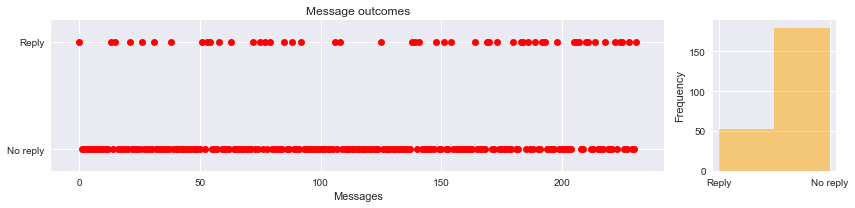

In [10]:
# Plot the data
fig = plt.figure(figsize=(12,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.plot(range(len(sent)), sent, 'ro')
ax2.hist(-sent, bins=2, alpha = .5, color = 'orange')

ax1.yaxis.set(ticks=(0,1), ticklabels=('No reply', 'Reply'))
ax2.xaxis.set(ticks=(-1,0), ticklabels=('Reply', 'No reply'));

ax1.set(title='Message outcomes', xlabel='Messages', ylim=(-0.2, 1.2))
ax2.set(ylabel='Frequency')

fig.tight_layout()


The plot above demonstrates the total number of messages sent, and the total number of replies. 

#### Now let's make function to plot outcomes for individual goups

In [11]:
def plot_outcomes(str):
    group = df.loc[  (df.Contact != 1 ) & (df.Ethnicity == str ), 'Response' ]   #messages sent by me to group 
    
    fig = plt.figure(figsize=(12,2))
    gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    ax1.plot(range(len(group)), group, 'ro')
    ax2.hist(-group, bins=2, alpha = .5, color = 'orange')

    ax1.yaxis.set(ticks=(0,1), ticklabels=('No reply', 'Reply'))
    ax2.xaxis.set(ticks=(-1,0), ticklabels=('Reply', 'No reply'));

    ax1.set(title='Message outcomes to {} group'.format(str), xlabel='Messages', ylim=(-0.2, 1.2))
    ax2.set(ylabel='Frequency')

    
    return fig.tight_layout()

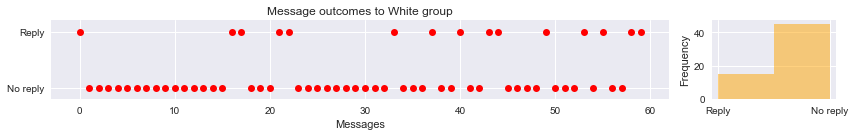

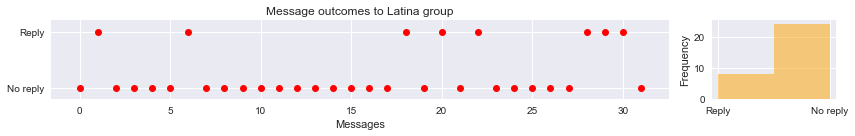

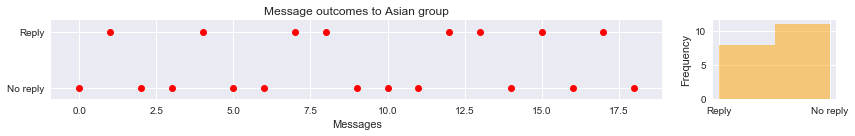

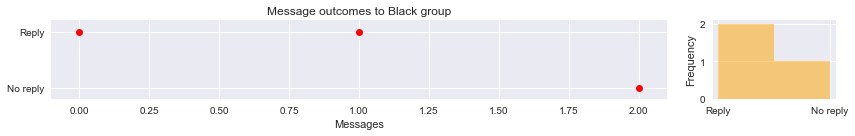

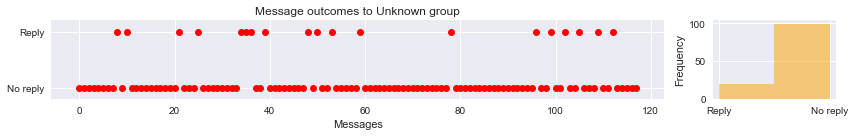

In [12]:
plot_outcomes("White"), plot_outcomes("Latina"), plot_outcomes("Asian"), plot_outcomes("Black"), plot_outcomes("Unknown");

### Histogram of Match % and messaged 

'Match % average of 78 with a median of 80'

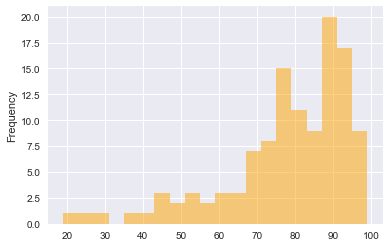

In [16]:
df.Match.plot.hist(alpha = .5, color = 'orange', bins=20);
match_mean = "%.0f" % df.Match.mean()
match_median = "%.0f" % df.Match.median()
'Match % average of {} with a median of {}'.format(match_mean, match_median)

According to OkCupid, the Match % demonstrates how well one matches up against a potential partner. From the histogram above we can see the median for matches contacted was 80%. 

#### 3. Choosing a Model

## Response rate for all contacted with Bayesian Statistics 
The reply data is modeled with a Bernoulli distribution. The distribution is a function of the parameter theta—the reply rate. Since we don't know much about my previous reply rates, we'll model theta prior as a Uniform distribution. 

In [17]:
with pm.Model():
    # prior 
    theta = pm.Uniform('theta', 0, 1) 
    
    # likelihood 
    Y = pm.Bernoulli('Y', p = theta, observed = sent )

    # Inference
    trace = pm.sample(4000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 126.98:   3%|▎         | 6855/200000 [00:01<00:31, 6148.64it/s]
Convergence archived at 7400
Interrupted at 7,400 [3%]: Average Loss = 138.08
100%|██████████| 4500/4500 [00:03<00:00, 1407.81it/s]


#### 4. Evaluating

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119574e48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1191e5a20>]], dtype=object)

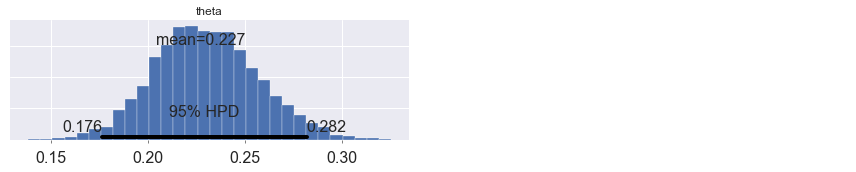

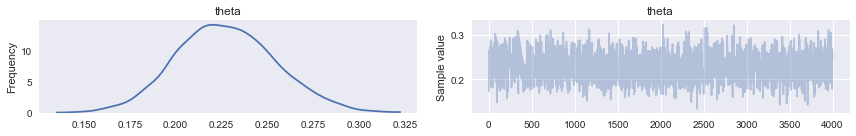

In [18]:
pm.plots.plot_posterior(trace)
pm.traceplot(trace)

In [20]:
pm.summary(trace)


theta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.227            0.027            0.001            [0.176, 0.282]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.177          0.208          0.226          0.245          0.282



I have an average reply rate of 22.7% with a 95 % CI (17.6%, 28.2%). From the plot below we see this is in agreement with OKC data for a Latino male. The next step is to look at response rate per individual groups.

<img src="../figures/Reply_rate_by_sender.png">
Source: [OkCupid Blog](https://theblog.okcupid.com/how-your-race-affects-the-messages-you-get-39c68771b99e)

#### 5. Hyperparameter tuning

## Hierarchical Model:  A/B Test  

In the Classical Bernoulli distribution, I assumed a uniform prior. However, we can use a Beta distribution, with hyper parameters a and b. This custom Beta distribution returns the logit, which incorporates the mean log(a/b) and the log of the "sample size", log(a+b). This analysis incorporates ideas about the logit to get desired mathematical properties when sampling for a and b.

Below I build a dataframe with trials and success for each group

In [43]:
Groups = ['White', 'Latina', 'Asian', 'Black', 'Unknown']

#function to build array for dataframe 
def n_trials(group_list):
    new_array = []
    for item in group_list:
        a =  df.loc[  (df.Contact != 1 ) & (df.Ethnicity == item ), 'Response' ].sum() #replies 
        b = len( df.loc[  (df.Contact != 1 ) & (df.Ethnicity == item ), 'Response' ] ) #messages sent to specific group
        new_array.append([a,b])
    return pd.DataFrame( np.array(new_array).reshape(5,2), columns = ['Replies', 'Sent'] ).set_index([group_list])

df1 = (n_trials(Groups))
df1

,Replies,Sent
White,15.0,60.0
Latina,8.0,32.0
Asian,8.0,19.0
Black,2.0,3.0
Unknown,19.0,118.0


In [10]:
import pymc

@pymc.stochastic(dtype=np.float64)
def hyperpriors(value=[1.0, 1.0]):
    a, b = value[0], value[1]
    if a <= 0 or b <= 0:
        return -np.inf
    else:
        return np.log(np.power((a + b), -2.5))

a = hyperpriors[0]
b = hyperpriors[1]

In [11]:
# The hidden, true rate for each group.
true_rates = pymc.Beta('true_rates', a, b, size=5)

# The observed values
trials = df1.Sent.as_matrix() #Passes array of values 
successes = df1.Replies.as_matrix() #Passes array 
observed_values = pymc.Binomial('observed_values', trials, true_rates, observed=True, value=successes)

model = pymc.Model([a, b, true_rates, observed_values])
mcmc = pymc.MCMC(model)

# Generate 1M samples, and throw out the first 500k
mcmc.sample(1000000, 500000)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 186.8 sec

/Users/cristian/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


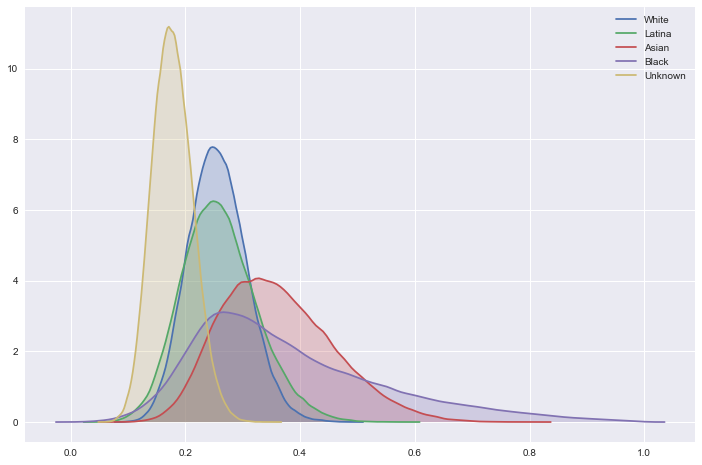

In [12]:
plt.figure(figsize=(12,8))
for i in range(5):
    sns.kdeplot(mcmc.trace('true_rates')[:][:,i], shade = True, label = Groups[i])

In [44]:
# save means to list 
true_rate = []
for i in range(5):
    true_rate.append( mcmc.trace('true_rates')[:][:,i].mean() ) 

# save means to df
df1['True rate %']  = pd.DataFrame({'True rate %': true_rate}, index=df1.index)
df1['True rate %'] = (df1['True rate %']*100).round(2)

In [45]:
df1

,Replies,Sent,True rate %
White,15.0,60.0,25.67
Latina,8.0,32.0,25.97
Asian,8.0,19.0,36.02
Black,2.0,3.0,37.99
Unknown,19.0,118.0,17.79


In [20]:
mcmc.summary()

/Users/cristian/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)



true_rates:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.257            0.051            0.001            [ 0.159  0.356]
	0.26             0.065            0.001            [ 0.138  0.393]
	0.36             0.097            0.002            [ 0.187  0.555]
	0.38             0.165            0.004              [ 0.12  0.74]
	0.178            0.035            0.001            [ 0.111  0.247]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.163            0.221           0.255          0.29          0.361
	0.143            0.214           0.256          0.301         0.401
	0.199            0.289           0.351          0.423         0.571
	0.146            0.258           0.343          0.472         0.787
	0.114            0.153           0.176          0.201         0.25


In [46]:
HPD = [ '15.9, 35.6', '13.8, 39.3', '18.7, 55.5', '12, 74',  '11.1, 24.7' ] 
df1['95% Credible Interval']  = pd.DataFrame({'95% Credible interval': HPD}, index=df1.index)
df1

,Replies,Sent,True rate %,95% Credible Interval
White,15.0,60.0,25.67,"15.9, 35.6"
Latina,8.0,32.0,25.97,"13.8, 39.3"
Asian,8.0,19.0,36.02,"18.7, 55.5"
Black,2.0,3.0,37.99,"12, 74"
Unknown,19.0,118.0,17.79,"11.1, 24.7"


1. Gathering Data
2. Preparing that data
3. Choosing a Model
4. Training
5. Evaluating
6. Hyperparameter tuning
7. Prediction 

# Conclusion 

### In person Meeting percentage 

In [14]:
with pm.Model():
    # prior 
    theta = pm.Uniform('theta', 0, 1) 
    
    # likelihood 
    Y = pm.Bernoulli('Y', p = theta, observed = df.Meeting )

    # Inference
    trace = pm.sample(5000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 28.195:   5%|▍         | 9691/200000 [00:01<00:25, 7398.01it/s]
Convergence archived at 9700
Interrupted at 9,700 [4%]: Average Loss = 79.102
100%|██████████| 5500/5500 [00:03<00:00, 1516.30it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e33bf60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e4141d0>]], dtype=object)

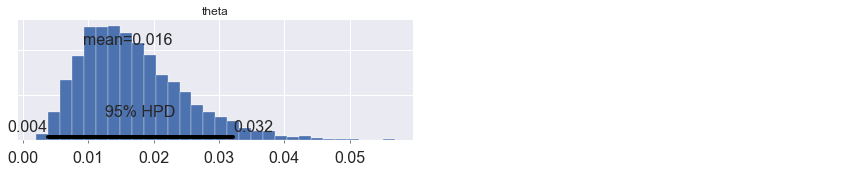

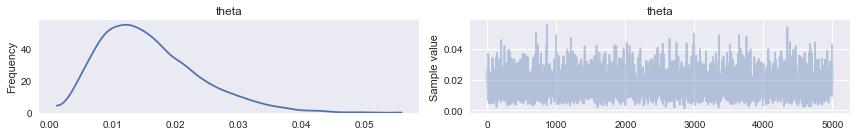

In [15]:
pm.plots.plot_posterior(trace)
pm.traceplot(trace)

In [16]:
pm.summary(trace)


theta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.016            0.008            0.000            [0.004, 0.032]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.005          0.010          0.015          0.021          0.035

